# Preliminary modelling for Turnip motor

Due to the use of self-pressurising nitrous oxide on the oxidiser side and "semi-blowdown" carbon dioxide as a pressurant for the fuel side, both propellant tank pressures - and hence the combustion chamber pressure - will drop over the course of the burn. Moreover, the oxidiser and fuel pressures will not necessarily drop at the same rate, resulting in a shifting O/F ratio over time. This adds some extra constraints to the design:

* The choice of initial injector pressure drop needs some thought. For stability we want (based on the rule of thumb that I was taught) at least a 15% pressure drop across both fuel and oxidiser injectors. The pressure falloff over time (effectively throttling down the motor) means we will need a drop higher than this initially - and the differing falloff rates for the fuel and oxidiser sides will add further constraints to ensure both components have at least this high a pressure drop at all times. 
* Do we want to keep the O/F ratio rich of stoichiometric? My first thought is that the use of film cooling should protect chamber walls from the more-corrosive hot gas at an oxidiser-rich O/F ratio, but some initial tests may be done without film cooling. Something to think about.

These may be a challenge. This quick simplified model should tell us exactly how much of a challenge it'll be.

For argument's sake, I'm assuming isopropyl alcohol is used as a fuel here. Other fuels (ethanol, methanol, gasoline, kerosene, ...) are also possible, and will vary in performance slightly.

## Lookup Tables

The specific impulse, gas temperature, $\gamma$, $C^*$, and various other important properties will all change with O/F ratio and chamber pressure. While we're thinking about that, we might as well also consider the small error introduced when calculating specific impulse from a given $C^*$ and $\gamma$ - it's small, but non-zero, depending on what value of $\gamma$ the thermodynamic software has given you.

To model all of this, I'll be taking a brute force approach: using the Nested Analysis function of thermodynamic software [RPA](http://www.propulsion-analysis.com/) to build a three-dimensional lookup table, and then using it to do piecewise linear interpolation of the important properties. The code to do this has been lifted (with minor tweaks and simplifications) from part of the launch vehicle optimisation code I wrote for the British Interplanetary Society's Nanosat Launch Vehicle Feasibility Study.

If you're reading this on GitHub: I haven't uploaded the engine data files, to avoid taking up several unnecessary megabytes on Github. If you want a copy please email Rob. :)

In [130]:
import numpy as np
import scipy.ndimage.interpolation as spimint
import os

# RPA exports data as text files, which are slower to load - so, if only the text file is available, 
# convert to binary NPY file to speed up future runs.
if os.path.isfile('n2o-ipa-data.npy'):
    data = np.load('n2o-ipa-data.npy')
else:
    data = np.loadtxt('n2o-ipa-data.txt')
    np.save('n2o-ipa-data.npy', data)
    print('Saved NPY version of data to speed up subsequent runs.')

dimensions = [59, 9, 28]

# Upper and lower values for O/F ratio, chamber pressure, and nozzle area ratio.
OFbounds = [0.5, 15.0]
pcbounds = [1.0e6, 5.0e6] # in Pa
erbounds = [3.0, 30.0]

# Extract useful parts of the data, and rearrange into 3D grids ("images" in np nomenclature).
vac_Isp_img = (np.reshape(data[:,11],dimensions)) # has RPA correction factor 
Cfopt_img = (  np.reshape(data[:,12],dimensions)) # doesn't
Cfvac_img = (  np.reshape(data[:,13],dimensions)) # also doesn't have the c. factor
cfactor_img = (np.reshape(data[:,14],dimensions)) # this is the correction factor

#point is: (OF ratio, P_c, nozzle area ratio)
def lookupValue(point, image):
    
    OFRcoord = (point[0]-OFbounds[0])/(OFbounds[1]-OFbounds[0])*(dimensions[0]-1)
    p_ccoord = (point[1]-pcbounds[0])/(pcbounds[1]-pcbounds[0])*(dimensions[1]-1)
    exrcoord = (point[2]-erbounds[0])/(erbounds[1]-erbounds[0])*(dimensions[2]-1)

    return spimint.map_coordinates(image,[[OFRcoord],[p_ccoord],[exrcoord]],mode='nearest',prefilter=False,order=1)


##useful functions    
def vac_Isp(point):
    return lookupValue(point,vac_Isp_img)*9.8065

def Cfvac_lookup(point):
    return lookupValue(point,Cfvac_img)

# RPA has two correction factors: "reaction efficiency" and "nozzle efficiency". 
# These are applied inconsistently in various places, making it possible to eliminate them.
#
# In particular: the Cfvac is not corrected, the product of the two correction factors is given, and the 
# given c* only has one correction factor applied, so it's necessary to instead figure out the uncorrected v_e 
# and then divide by the (uncorrected) C_fvac 

def uncorrected_cstar(point):
    actual_vac_Isp = vac_Isp(point)/lookupValue(point,cfactor_img)
    
    if not lookupValue(point,cfactor_img)>0.8:
        print(point)
        print('had an error!')
    
    if point[0] < 30:
        return actual_vac_Isp/lookupValue(point,Cfvac_img)
    else:
        return 135*np.sqrt(273/44) # Assume that these O/F ratios represent only a flow of cold N2O. 
                                   # Actually, it's likely to be colder than this, but the resulting error is small. 
    
def exit_pressure(point):
    cfdiff = lookupValue(point,Cfvac_img)-lookupValue(point,Cfopt_img)
    return cfdiff*point[1]/point[2]

print("Example: vacuum exhaust velocity (assuming 100% c* eff) at 3.5 MPa P_c, 5.6 O/F ratio, and Ae/At = 10 is {:.2f} m/s.".format(vac_Isp([5.6, 3.5e6, 10])[0]))

Example: vacuum exhaust velocity (assuming 100% c* eff) at 3.5 MPa P_c, 5.6 O/F ratio, and Ae/At = 10 is 2596.29 m/s.


## Combustion Chamber Model

The combustion chamber is modelled in essentially the simplest-possible way. All that this model really does is add a small time delay between the injection of a certain mass of propellant and its effects on combustion chamber pressure - but it also acts as a "placeholder" for more advanced combustion chamber models if those look like fun to make later.

In particular: it is assumed to contain two masses of fuel and oxidiser droplets, $m_{oc}$ and $m_{fc}$. It is assumed that the droplet size distribution and the absorbed heat flux are constant, so that the rate at which they evaporate is proportional to their mass. (Big errors in these assumptions: droplet size distribution will vary with injection speed; absorbed heat flux will vary with droplet size distribution and combustion chamber pressure. However, it is very difficult to put together accurate models of these dependencies, so I've instead gone for the simple approach and would note that any transient phenomena modelled this way should be taken with a pinch of salt. The size of the pinch of salt is proportional to the speed of the transient effect. Fortunately, no "sharp" transients on the scale of the modelled residence time appear to happen in this model, so no time needs to be wasted worrying about the effects of this.)

The masses of droplets are replenished by injected fuel and oxidiser at rates $\dot{m_f}$ and $\dot{m_o}$. These will be examined in more detail later in this notebook. The ODE for chamber masses is thus

$\begin{align}
\frac{dm_{oc}}{dt} = \dot{m_o} - k_{oce}m_{oc} \\ \\
\frac{dm_{fc}}{dt} = \dot{m_f} - k_{fce}m_{fc}
\end{align}$

where $k_{oce}$ and $k_{fce}$ are constants related to the rate of evaporation of the propellant droplets. Moreover, it is assumed that the evaporated gases instantly mix, react and exit the chamber. This means that the combustion chamber pressure can be calculated as follows:

$\begin{align}
P_c = \frac{\dot{m}}{A_e}\eta_{C^*}C^* = \frac{1}{A_e}(k_{oce}m_{oc}+k_{fce}m_{fc})\eta_{C^*}C^*\left(\frac{k_{oce}m_{oc}}{k_{fce}m_{fc}}, P_c\right)
\end{align}$

where $\dot{m}$ denotes the total mass flux out of the combustion chamber, $A_e$ the nozzle exit area, $\eta_{C^*}$ is the $C^*$ efficiency, and $C^*(OF, P_c)$ denotes the $C^*$ at a given O/F ratio and pressure. Note that this must be solved iteratively, but it will converge quickly because $C^*$ varies very little with pressure.

Putting all this together, the example code below demonstrates this model. It is assumed that the fuel and oxidiser tank pressures drop linearly with time, with the fuel pressure dropping from 5 MPa to 3 MPa over ten seconds and the oxidiser pressure dropping from 4.5 MPa to 3.5 MPa over the same period. It is also assumed that the injected propellants are both incompressible liquids, so that the propellant mass flow is given by $\dot{m_p} = C_dA\sqrt{2\rho_p (P_t - P_c)}$ where $P_t$ denotes tank pressure, $C_d$ denotes coefficient of discharge for the injector orifices, and $\rho_p$ denotes the density of the propellant.

In [131]:
# Example code. Values for evaporation coefficient, throat area, and C_D×A values are based on a 500 N motor 
# with a tank pressure of 4.5 MPa, a combustion chamber pressure of 3.5 MPa, an O/F ratio of 5.8, and a 
# propellant residence time of 1.58 ms.

from scipy.integrate import ode

## useful constants
c_star_eff = 0.9
rho_o = 820.9 
rho_f = 786.0

A_t = 0.25*np.pi*(0.01113)**2 #throat area
Ae_by_At = 5.444 # nozzle area ratio

theta_E = np.deg2rad(7.5) # nozzle half-angle of 7.5 degrees

## reference motor stuff, used to calculate k_oce, k_fce, C_D×A for fuel and oxidiser orifices
ref_chamber_press = 3.5e6
ref_tank_press = 4.5e6
ref_OF_ratio = 5.8
ref_residence_time = 0.00158 #calculated elsewhere. roughly equal to an L* of 1 metre, for this motor, I think.
ref_mdot = 0.2179 #total mass flow for the motor

ref_f_mdot = ref_mdot*(1/(1+ref_OF_ratio))
ref_o_mdot = ref_f_mdot * ref_OF_ratio

## values derived from the reference motor
k_oce = 1/ref_residence_time
k_fce = 1/ref_residence_time

inj_ACD_fuel = ref_f_mdot/np.sqrt(2*rho_f*(ref_tank_press-ref_chamber_press)) #C_D×A for fuel injector orifices
inj_ACD_ox   = ref_o_mdot/np.sqrt(2*rho_o*(ref_tank_press-ref_chamber_press)) #C_D×A for oxidiser injector orifices

def P_tank_oxidiser(t):
    if t<10:
        return 4.5e6-t*0.1e6
    else:
        return 0.0
    
def P_tank_fuel(t):
    if t<10:
        return 5.0e6-t*0.2e6
    else:
        return 0.0
    
def calculate_P_c_and_Cstar(A_t, OF_ratio, mdot):
    Pc_guess = ref_chamber_press
    err = 500
    ii = 0
    
    #print("attempting to guess")
    
    while err > 1e-3 and ii < 20:
        Cstar = uncorrected_cstar([OF_ratio, Pc_guess, Ae_by_At])
        new_Pc_guess = mdot/A_t*c_star_eff*Cstar
        err = abs(Pc_guess - new_Pc_guess)
        Pc_guess = new_Pc_guess
        ii+=1
        
        #print(Cstar, Pc_guess)
        
    return (Pc_guess, Cstar)

def state_derivative(t,state):
    m_oc = state[0]
    m_fc = state[1]
    
    ox_out_mdot = m_oc*k_oce
    fuel_out_mdot = m_fc*k_fce
    
    #print(ox_out_mdot, fuel_out_mdot)
    
    OF_ratio = ox_out_mdot/fuel_out_mdot
    
    #print(OF_ratio)
    
    P_c, Cstar = calculate_P_c_and_Cstar(A_t, OF_ratio, ox_out_mdot+fuel_out_mdot)
    
    ox_in_mdot = inj_ACD_ox*np.sqrt(2*rho_o*(P_tank_oxidiser(t)-P_c))
    fuel_in_mdot = inj_ACD_fuel*np.sqrt(2*rho_f*(P_tank_fuel(t)-P_c))

    p_exit = exit_pressure([OF_ratio, P_c, Ae_by_At])

    
    ideal_cfvac = Cfvac_lookup([OF_ratio, P_c, Ae_by_At])
    corrected_cfvac= ideal_cfvac*0.5*(1+np.cos(theta_E)) # ignores drag loss.
    corrected_cfsl = corrected_cfvac - (Ae_by_At * (101325.0/P_c))
    
    vac_isp = corrected_cfvac*Cstar*c_star_eff
    sl_isp = corrected_cfsl*Cstar*c_star_eff
    
    vac_thrust = vac_isp * (ox_out_mdot+fuel_out_mdot)
    sl_thrust = sl_isp * (ox_out_mdot+fuel_out_mdot)
    
    ret1 = np.array([ox_in_mdot-ox_out_mdot, fuel_in_mdot-fuel_out_mdot])
    ret2 = np.array([P_c, OF_ratio, Cstar, p_exit, vac_isp, sl_isp, vac_thrust, sl_thrust])
    
    return ret1, ret2 

In [132]:
## now run an example
num_points = 100
time_res = 0.1

state0 = np.array([0.00008, 0.00001])
t0 = 0

r = ode(state_derivative)
r.set_initial_value(state0,t0)

stateHist = np.zeros((2,num_points))
extraHist = np.zeros((8,num_points))
tankpressHist = np.zeros((2,num_points))
time = np.zeros(num_points)

for ii in range (1,num_points):
    t = ii*time_res
    
    r.integrate(t)
    
    derivative, extraInfo = state_derivative(t, r.y)
    
    stateHist[:, ii] = r.y
    extraHist[:, ii] = extraInfo
    tankpressHist[:,ii] = np.array([P_tank_oxidiser(t),P_tank_fuel(t)])
    time[ii] = t
    
    if ii % (num_points/10) == 0:
        print('|', end='')
    else:
        print('.', end='')
        
print('\n done!')

.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 done!


Populating the interactive namespace from numpy and matplotlib
Total sea level impulse: 4318.2 Ns


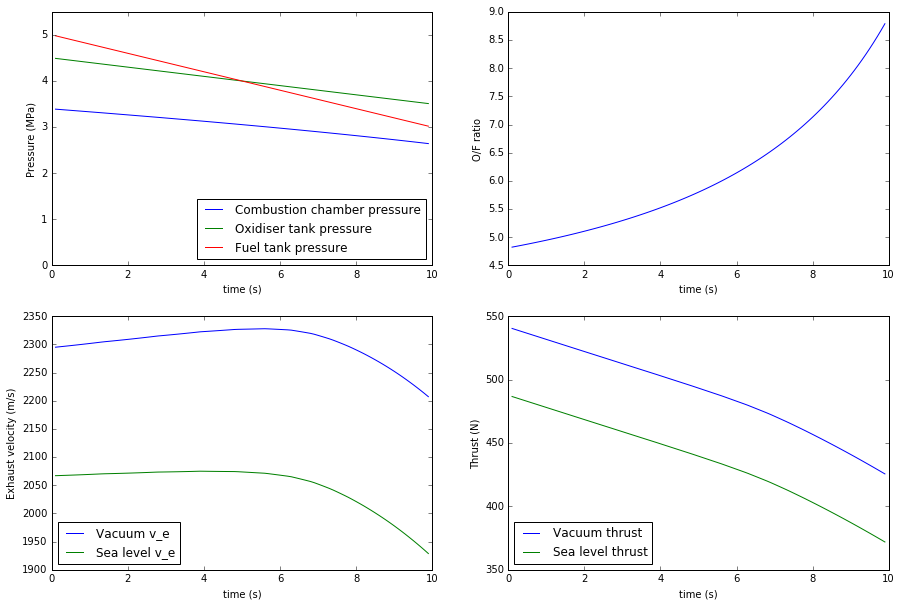

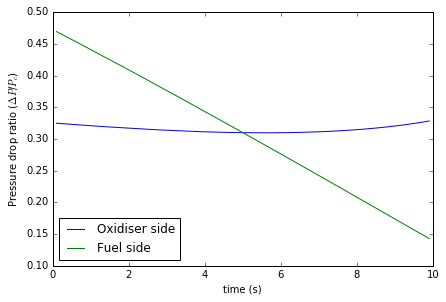

In [133]:
import matplotlib.pyplot as plt
%pylab inline

figsize(15,10)

fig=plt.figure()


sp1=fig.add_subplot(221)
sp1.plot(time[1:],extraHist[0,1:]/1e6, label="Combustion chamber pressure")
sp1.plot(time[1:],tankpressHist[0,1:]/1e6, label="Oxidiser tank pressure")
sp1.plot(time[1:],tankpressHist[1,1:]/1e6, label="Fuel tank pressure")
sp1.set_ylim([0,5.5])
sp1.legend(loc=4)
sp1.set_xlabel("time (s)")
sp1.set_ylabel("Pressure (MPa)")

sp2 = fig.add_subplot(222)
sp2.plot(time[1:],extraHist[1,1:])
sp2.set_xlabel("time (s)")
sp2.set_ylabel("O/F ratio")

sp3 = fig.add_subplot(223)
sp3.plot(time[1:],extraHist[4,1:], label="Vacuum v_e")
sp3.plot(time[1:],extraHist[5,1:], label="Sea level v_e")
sp3.legend(loc=3)
sp3.set_xlabel("time (s)")
sp3.set_ylabel("Exhaust velocity (m/s)")

sp4 = fig.add_subplot(224)
sp4.plot(time[1:],extraHist[6,1:], label="Vacuum thrust")
sp4.plot(time[1:],extraHist[7,1:], label="Sea level thrust")
sp4.legend(loc=3)
sp4.set_xlabel("time (s)")
sp4.set_ylabel("Thrust (N)")

fig2 = plt.figure()
sp5 = fig2.add_subplot(221)
sp5.plot(time[1:], tankpressHist[0,1:]/extraHist[0,1:]-np.ones_like(time[1:]), label="Oxidiser side")
sp5.plot(time[1:], tankpressHist[1,1:]/extraHist[0,1:]-np.ones_like(time[1:]), label="Fuel side")
sp5.legend(loc=3)
sp5.set_xlabel("time (s)")
sp5.set_ylabel("Pressure drop ratio ($\Delta P$/$P_c$)")


print("Total sea level impulse: {:.1f} Ns".format(np.sum(extraHist[7,1:])*time_res))

The example above highlights some of the things that drive the design. For example:

* As is well-known from its use in hybrids, nitrous oxide is very forgiving in terms of performance losses when running off-mixture: the O/F ratio ranged from ~4.8 to ~9.2 in this example, but the specific impulse only varied by around 10%. (Yes, that range crosses the optimum, so it'd be more accurate to say "the O/F ratio goes from the optimal value of ~5.5 to ~9.2 and the specific impulse only dropped by about 10%)
* If the fuel pressure drops off much more rapidly than the oxidiser pressure, we can expect to see significant O/F shifts and a relatively low pressure drop on the fuel side towards the end of the burn. Re-run the example with different fuel pressure dropoff rates to see more and less extreme versions of this.
* If a significant difference in dropoff rate between fuel and oxidiser does occur, then a large initial pressure drop for the fuel side may be necessary. This corresponds to very small injector orifices: in the example above, the total injector orifice areas are 1.15 mm² and 6.55 mm² (assuming $C_D$ = 0.7). Depending on the injector configuration, going much smaller than this may pose challenges. (Of course, in practice nitrous oxide generally can't be modelled as an incompressible liquid, so this injector orifice area is an underestimate.)

## Self-pressurised nitrous oxide

Modelling self-pressurised nitrous oxide can be fairly complicated. See the AspireSpace paper [The Physics of Nitrous Oxide](http://aspirespace.org.uk/downloads/The%20physics%20of%20nitrous%20oxide.pdf) for a quick introduction, and [Modelling the Nitrous Run Tank Emptying](http://aspirespace.org.uk/downloads/Modelling%20the%20nitrous%20run%20tank%20emptying.pdf) for an application of this to hybrid rocket motors.

The approach taken for this analysis is based on the equilibrium model presented in Zimmerman et al's paper [Review and Evaluation of Models for
Self-Pressurizing Propellant Tank Dynamics](https://web.stanford.edu/~cantwell/Recent_publications/Zimmerman_et_al_AIAA_2013-4045.pdf), with some extra simplifications and omissions, and the use of a single-phase incompressible model with a "loss coefficient" to calculate injector mass flow. I believe this is more or less equivalent to the model presented in the second Aspire paper above by Rick.

The nitrous oxide tank is modelled as a two-node equilibrium system: that is, we consider only the properties of the gaseous component and the liquid component as lumped parameters; we also assume that they have equal temperature and pressure, and at all times are saturated (the liquid's temperature is such that its vapor pressure is equal to the pressure in the tank). It is assumed that as the liquid phase drains out and the pressure drops, some of the liquid boils instantly to replenish the lost gas, and that the tank remains in equlibrium.

Two state variables are used in this model: the total mass of fluid in the tank $m_{tot}$ and the total internal energy of the tank $U_{tot}$. This latter is equal to the product of pressure and volume of the tank, plus the enthalpies of the liquid and gas phase. This model actually makes the differential equations very simple: if we know the mass flow out of the tank and whether it's the liquid or gas phase, then the rate of change of internal energy is simply the mass flow times the specific internal energy of that phase. In other words:

$\frac{dm_{tot}}{dt} = \dot{m}$

$\frac{dU_{tot}}{dt} =     \begin{cases}
      \dot{m}{U_{\text{specific (liquid)}}} & \text{for outflowing liquid} \\
      \dot{m}{U_{\text{specific (vapor)}}} & \text{for outflowing vapor}
    \end{cases}$

where $\dot{m}$ is a placeholder for the mass flow rate through the injector which we determine later.

The bad news is that for a fluid relatively near to its critical point, getting from this model to more useful properties (pressure, temperature, density, ...) isn't trivial. The good news is that there's a thermodynamic tool called CoolProp which gives easy-to-use and reasonably quick lookup functions for these properties, which we can just use as black boxes in Python. 

From the mass and total internal energy, and using the assumption that the nitrous oxide is at saturation, it is possible to calculate the fraction of mass which is vapour:

$\begin{align}
m_{f (vapour)} = \frac{\frac{U_{tot}}{m_{tot}} - u_{liq}}{u_{vap}-u_{liq}} \end{align}$

where $u_{liq}$ and $u_{vap}$ are the specific internal energies of the liquid and gaseous phases respectively, and can be calculated by CoolProp using from the current temperature.

Similarly, given $U_{tot}$, $m_{tot}$, $T$ and $m_{f (vapour)}$, we can calculate the total tank volume.

$\begin{align}
V_{tank} = m_{tot}\left(\frac{1-m_{f (vapour)}}{\rho_{liq}} + \frac{m_{f (vapour)}}{\rho_{vap}} \right)
\end{align}$

where $\rho_{liq}$ and $\rho_{vap}$ can be calculated by CoolProp under the saturation assumption and the current fluid temperature $T$.

Unfortunately, at this point, we must resort to numerical methods to calculate $T$. In particular, since $V_{tank}$ is a known (constant) value at any given time, we can iteratively solve the equation above to find a temperature at which the calculated tank volume matches the known tank volume. This is done in the code below in the ``findTemp`` function.

The flow of saturated nitrous oxide through an injector orifice is also tricky to model, as some (or all, depending on pressure ratios, injector geometry, and heat flow from the combustion chamber) of the fluid will flash to vapour. The simplest way to model this is just to model it as a single-phase incompressible flow, but with a "loss coefficient" (effectively a reduced coefficient of discharge) to model the effects of needing to push a lower-density foam through the injector: as before, $\dot{m_o} = KC_dA\sqrt{2\rho_o (P_t - P_c)}$, where $K < 1$ is the new loss coefficient.

The example below demonstrates this, with a 1-litre tank of saturated nitrous oxide at 4.3 MPa exhausting into a chamber which drops from 3 MPa to 2 MPa over the course of 5 seconds.

In [134]:
import CoolProp.CoolProp as cp
import scipy.optimize as spopt

## some more readable wrappers for CoolProp functions
def satPressure(T, fluidName):
    return cp.PropsSI('P', 'T', T, 'Q', 0, fluidName)

# 'Q' means 'quality' - a term from steam systems, I believe. Here Q=0 means "liquid phase" and Q=1 means "gas phase".
def satLiquidDensity(T, fluidName):
    return cp.PropsSI('D', 'T', T, 'Q', 0, fluidName) 

def satGasDensity(T, fluidName):
    return cp.PropsSI('D', 'T', T, 'Q', 1, fluidName)

def satLiquidSpecEnthalpy(T, fluidName): #J/kg
    return cp.PropsSI('H', 'T', T, 'Q', 0, fluidName)
    
def satGasSpecEnthalpy(T, fluidName): #J/kg
    return cp.PropsSI('H', 'T', T, 'Q', 1, fluidName)    

def satGasSpecIntEnergy(T, fluidName):
    specVol=1/satGasDensity(T, fluidName) #1/density
    vapPress=satPressure(T, fluidName)
    return satGasSpecEnthalpy(T, fluidName)-specVol*vapPress

def satLiquidSpecIntEnergy(T, fluidName):
    specVol=1/satLiquidDensity(T, fluidName) #1/density
    vapPress=satPressure(T, fluidName)
    return satLiquidSpecEnthalpy(T, fluidName)-specVol*vapPress

## equilibrium-model-specific helper 
def vaporMassFraction(Utot, mtot, T, fluidName):
    u_vap=satGasSpecIntEnergy(T, fluidName)
    u_liq=satLiquidSpecIntEnergy(T, fluidName)
    
    return (Utot/mtot-u_liq)/(u_vap-u_liq)

def vaporMass(Utot,mtot,T, fluidName):
    return mtot*vaporMassFraction(Utot,mtot,T, fluidName)

def liquidMass(Utot,mtot,T, fluidName):
    return mtot-vaporMass(Utot,mtot,T, fluidName)

# Tank volume required to contain a given mass of saturated fluid at temperature T and total internal energy Utot.
# Basically just inverse of density.
def VTank(Utot,mtot,T,fluidName):
    x = vaporMassFraction(Utot,mtot,T, fluidName)
    
    rho_liq = satLiquidDensity(T, fluidName)
    rho_gas=satGasDensity(T, fluidName)
    
    return mtot*((1-x)/rho_liq+x/rho_gas)

def findTemp(mtot,Utot,V_tank,fluidName,P_guess=1e6):
    
    # The pressure guess isn't used beyond this point - its only purpose is to make a reasonable initial guess of T.
    T_guess = cp.PropsSI('T', 'P', P_guess, 'Q', 0, fluidName)
    
    def f(T):
        return VTank(Utot,mtot,T,fluidName)-V_tank
    
    return spopt.fsolve(f,T_guess)
    
def tempFromSatPressure(P,fluidName):   
    return cp.PropsSI('T', 'P', P, 'Q', 0, fluidName)

## Injected fluid functions
#Single Phase Incompressible: just model it as an incompressible fluid
def mdot_SPI(AC_D, P_tank, P_chamber, rho_tank, density):
    return AC_D*np.sqrt(2*rho*(P_tank-P_chamber))

## Example blowdown:
def example_P_C(t):
    if t < 4.5:
        return 3.0e6 - t*0.2e6
    else:
        return 2.1e6 - (t-4.5)*1e6

def n2o_state_derivative(t,state,V_tank,C_dAK,init_liq_mass): # that last, ugly, parameter is C_d×A×K where A is total injector area 
    mtot=state[0]
    Utot=state[1]
    
    T=findTemp(mtot,Utot,V_tank,'NitrousOxide')[0]
    
    rho_gas=satGasDensity(T,'NitrousOxide')
    rho_liq=satLiquidDensity(T,'NitrousOxide')
    P_tank=satPressure(T,'NitrousOxide')
    
    P_c = example_P_C(t) # Sometimes I regret the fact that this code has t and T meaning two different things.
    
    m_f_vapor = vaporMassFraction(Utot, mtot, T, 'NitrousOxide')
    
    if ((1-m_f_vapor)*mtot) > (0.01*initial_liq_mass):
        mdot=-C_dAK*np.sqrt(2*rho_liq*(P_tank-P_c))
        Udot=satLiquidSpecIntEnergy(T,'NitrousOxide')*mdot
    else:
        mdot=-C_dAK*np.sqrt(2*rho_gas*(P_tank-P_c))
        Udot=satGasSpecIntEnergy(T,'NitrousOxide')*mdot
    
    return [mdot,Udot], [T, P_c, P_tank, rho_gas, rho_liq, m_f_vapor, m_f_vapor*mtot, (1-m_f_vapor)*mtot ]

## now do the example
T_init = tempFromSatPressure(4.3e6, 'NitrousOxide') 
C_dAK = 4e-6
ullage_init = 0.05
V_tank = 1e-3

initial_vap_mass = V_tank*ullage_init*satGasDensity(T_init,'NitrousOxide')
initial_liq_mass = V_tank*(1-ullage_init)*satLiquidDensity(T_init,'NitrousOxide')

initial_m_tot = initial_vap_mass + initial_liq_mass
initial_U_tot = initial_vap_mass*satGasSpecIntEnergy(T_init,'NitrousOxide') \
                + initial_liq_mass*satLiquidSpecIntEnergy(T_init,'NitrousOxide')

state0 = np.array([initial_m_tot, initial_U_tot])

eg2_r = ode(n2o_state_derivative)
eg2_r.set_initial_value(state0, 0.)
eg2_r.set_f_params(V_tank, C_dAK, initial_liq_mass)

eg2_num_points = 680
eg2_time_res = 0.01

stateHist = np.zeros((2,eg2_num_points))
extraHist = np.zeros((8,eg2_num_points))
time = np.zeros(eg2_num_points)

derivative, extraInfo = n2o_state_derivative(0.0, eg2_r.y, V_tank, C_dAK, initial_liq_mass)
stateHist[:,0] = state0
extraHist[:,0] = extraInfo

lastperccomplete = 0

for ii in range (1,eg2_num_points):
    t = ii*eg2_time_res
    
    eg2_r.integrate(t)
    
    derivative, extraInfo = n2o_state_derivative(t, eg2_r.y, V_tank, C_dAK, initial_liq_mass)
    
    stateHist[:, ii] = eg2_r.y
    extraHist[:, ii] = extraInfo
    time[ii] = t

    perccomplete = ceil(100*ii/eg2_num_points)
    if (perccomplete>lastperccomplete):
        if (perccomplete % 10 == 0):
            print('|', end='')
        else:
            print('.', end='')
    lastperccomplete = perccomplete

            
print('\n done!')

.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|
 done!


Populating the interactive namespace from numpy and matplotlib


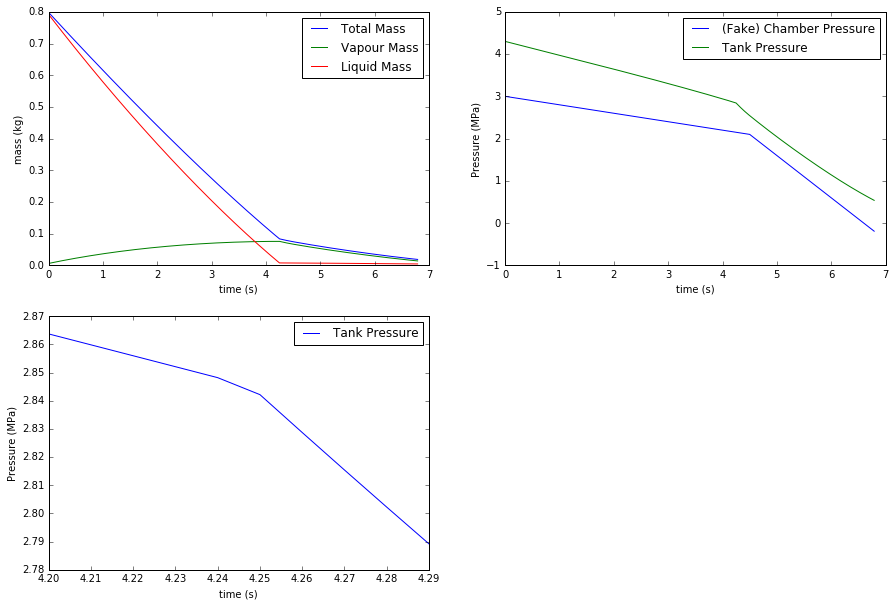

In [135]:
import matplotlib.pyplot as plt
%pylab inline

figsize(15,10)

fig=plt.figure()

sp1=fig.add_subplot(221)
sp1.plot(time[0:],stateHist[0,0:], label="Total Mass")
sp1.plot(time[0:],extraHist[6,0:], label="Vapour Mass")
sp1.plot(time[0:],extraHist[7,0:], label="Liquid Mass")
sp1.legend(loc=1)
sp1.set_xlabel("time (s)")
sp1.set_ylabel("mass (kg)")

sp2=fig.add_subplot(222)
sp2.plot(time,extraHist[1,:]/1e6, label="(Fake) Chamber Pressure")
sp2.plot(time,extraHist[2,:]/1e6, label="Tank Pressure")
sp2.legend(loc=1)
sp2.set_xlabel("time (s)")
sp2.set_ylabel("Pressure (MPa)")

#sp3=fig.add_subplot(223)
#sp3.plot(time,extraHist[5,:], label="Vapour Mass Fraction")
#sp3.legend(loc=2)
#sp3.set_xlabel("time (s)")

sp3=fig.add_subplot(223)
sp3.plot(time[420:430],extraHist[2,420:430]/1e6, label="Tank Pressure")
sp3.legend(loc=1)
sp3.set_xlabel("time (s)")
sp3.set_ylabel("Pressure (MPa)")

## Fuel pressurised with carbon dioxide

This consists of a volume full of carbon dioxide (some liquid, some gaseous) separated by a free-floating piston from a volume full of fuel. The dynamics are similar to the nitrous oxide example, but with some important differences:

* The mass in the pressurant volume remains constant, whereas the volume changes. 
* The internal energy of the pressurant does change, but the change is due to work done by expanding against the piston.
* The fuel is injected as an incompressible liquid, so we have a higher level of confidence in the injector mass flow rate model without experimental data.

Using the equilibrium model, we see that as the pressurant volume expands, liquid carbon dioxide will boil off and the system will stay on the saturation line. This will continue until all of the liquid has boiled off, at which point the remaining gas will expand isentropically. Two state variables are used, $V_{fu}$ and $U_{fu}$, for the volume and total energy of the fuel tank ullage contents, with the following ODE:

$
\dfrac{dV_{fu}}{dt} = \dfrac{\dot{m}}{\rho_f} \\ 
\dfrac{dU_{fu}}{dt} = - P_{ft}\dfrac{dV_{fu}}{dt}
$

where $\dot{m}$ is the fuel outlet mass flow rate, $\rho_f$ is the fuel density, and $P_{ft}$ is the fuel tank pressure.

In [136]:
rho_f = 786.0
P_initial = 4.3e6

def example_P_C(t):
    return 3.0e6 - t*1e6

def co2_state_derivative(t,state,m_pressurant,C_dAK,init_liq_mass): # that last, ugly, parameter is C_d×A×K where A is total injector area 
    Vtank=state[0]
    Utot=state[1]
    
    T=findTemp(m_pressurant,Utot,Vtank,'CarbonDioxide')[0]
    
    rho_gas=satGasDensity(T,'CarbonDioxide')
    rho_liq=satLiquidDensity(T,'CarbonDioxide')
    P_tank=satPressure(T,'CarbonDioxide')
    
    P_c = example_P_C(t)
    
    m_f_vapor = vaporMassFraction(Utot, m_pressurant, T, 'CarbonDioxide')
    
    if ((1-m_f_vapor)*m_pressurant) < (0.01*initial_liq_mass):
        print('out of liquid?')
    
    Vtankdot = (C_dAK*np.sqrt(2*rho_f*(P_tank-P_c)))/rho_f
    Udot = -P_tank*Vtankdot
    
    return [Vtankdot,Udot], [T, P_c, P_tank, rho_gas, rho_liq, m_f_vapor, m_f_vapor*m_pressurant, (1-m_f_vapor)*m_pressurant ]

T_init = tempFromSatPressure(P_initial, 'CarbonDioxide') 
C_dAK = 3e-6
pressurant_ullage_init = 0.05
initial_V_tank = 1e-4

initial_vap_mass = initial_V_tank*pressurant_ullage_init*satGasDensity(T_init,'CarbonDioxide')
initial_liq_mass = initial_V_tank*(1-pressurant_ullage_init)*satLiquidDensity(T_init,'CarbonDioxide')

m_tot = initial_vap_mass + initial_liq_mass

initial_U_tot = initial_vap_mass*satGasSpecIntEnergy(T_init,'CarbonDioxide') \
                + initial_liq_mass*satLiquidSpecIntEnergy(T_init,'CarbonDioxide')

state0 = np.array([initial_V_tank, initial_U_tot])

## example run

eg3_r = ode(co2_state_derivative)
eg3_r.set_initial_value(state0, 0.)
eg3_r.set_f_params(m_tot, C_dAK, initial_liq_mass)

eg3_num_points = 750
eg3_time_res = 0.002

stateHist = np.zeros((2,eg3_num_points))
extraHist = np.zeros((10,eg3_num_points))
time = np.zeros(eg3_num_points)

derivative, extraInfo = co2_state_derivative(0.0, eg3_r.y, m_tot, C_dAK, initial_liq_mass)
stateHist[:,0] = state0
extraHist[:,0] = np.append(derivative, extraInfo)

lastperccomplete = 0

for ii in range (1,eg3_num_points):
    t = ii*eg3_time_res
    
    eg3_r.integrate(t)
    
    derivative, extraInfo = co2_state_derivative(t, eg3_r.y, m_tot, C_dAK, initial_liq_mass)
    
    stateHist[:, ii] = eg3_r.y
    extraHist[:, ii] = np.append(derivative, extraInfo)
    time[ii] = t

    perccomplete = ceil(100*ii/eg3_num_points)
    if (perccomplete>lastperccomplete):
        if (perccomplete % 10 == 0):
            print('|', end='')
        else:
            print('.', end='')
    lastperccomplete = perccomplete
           
print('\n done!')

.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|
 done!


Populating the interactive namespace from numpy and matplotlib

Self-pressurised CO2 pressurant:

Pressure = 2851635.6 at volume ratio 2.33085
Pressure = 2849758.0 at volume ratio 2.33352

Nitrogen blowdown pressurant:

Pressure = 2858736.7 at volume ratio 1.33856
Pressure = 2849685.9 at volume ratio 1.34160


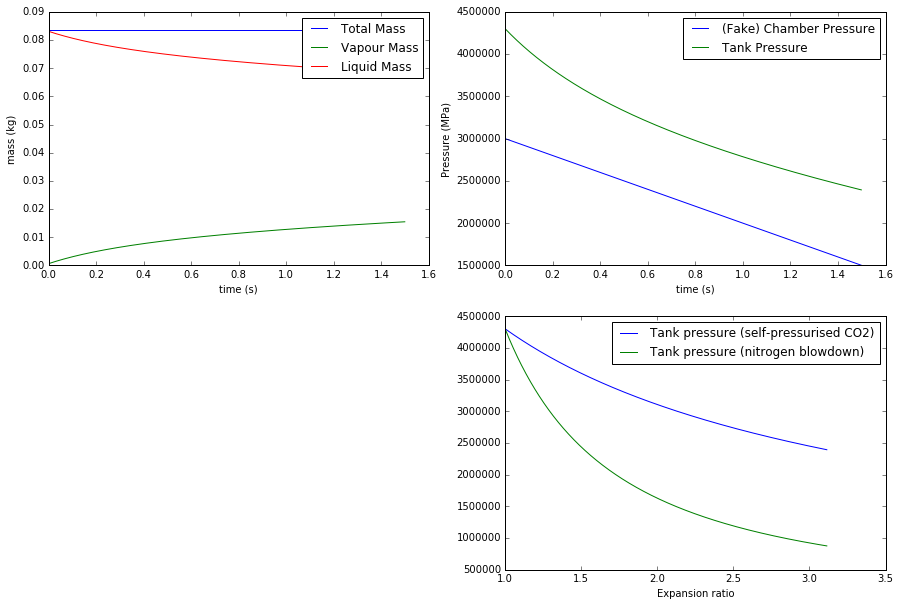

In [137]:
import matplotlib.pyplot as plt
%pylab inline

figsize(15,10)

fig=plt.figure()

sp1=fig.add_subplot(221)
sp1.plot(time[0:],extraHist[8,0:]+extraHist[9,0:], label="Total Mass")
sp1.plot(time[0:],extraHist[8,0:], label="Vapour Mass")
sp1.plot(time[0:],extraHist[9,0:], label="Liquid Mass")
sp1.legend(loc=1)
sp1.set_xlabel("time (s)")
sp1.set_ylabel("mass (kg)")

sp2=fig.add_subplot(222)
sp2.plot(time,extraHist[3,:], label="(Fake) Chamber Pressure")
sp2.plot(time,extraHist[4,:], label="Tank Pressure")
sp2.legend(loc=1)
sp2.set_xlabel("time (s)")
sp2.set_ylabel("Pressure (MPa)")

# Pressures at different expansion volume ratios if we used a diatomic gas like nitrogen which expanded isentropically.
nitrogen_blowdown_version = P_initial*(stateHist[0,:]/initial_V_tank)**(-1.4)

sp4=fig.add_subplot(224)
sp4.plot(stateHist[0,:]/initial_V_tank,extraHist[4,:], label="Tank pressure (self-pressurised CO2)")
sp4.plot(stateHist[0,:]/initial_V_tank, nitrogen_blowdown_version, label="Tank pressure (nitrogen blowdown)")
sp4.legend(loc=1)
sp4.set_xlabel("Expansion ratio")

ref_pressure = 2.85e6

print('\nSelf-pressurised CO2 pressurant:\n')

# The two lines of code are quite elegant if you like Python, but are hard to unravel. Each does the following:
#  - Create a Boolean array of whether elements in a particular array satisfy a condition: so, for instance,
#    extraHist[4,:] > 2.85e6 creates an array [True, True, ... , True, False, False, ...] with values
#    which are True when the pressure logged in that row of extraHist is > 2.85 MPa and false otherwise
#  - Uses the Boolean array as an index for the original array (building a new array which, in the example, 
#    contains all of the pressures above 2.85 MPa)
#  - Select the first or last element depending on which one we're looking at: this will give either the last pressure
#    larger than the threshold or the first pressure below the threshold.
#  - Repeat the above two steps using the Boolean array as an index for the volume ratio.
#
# Short version: "Use Pythonic magic to select the points before and after the pressure threshold.

print('Pressure = {:.1f} at volume ratio {:.5f}'.format(extraHist[4,:][extraHist[4,:] > ref_pressure][-1], stateHist[0,:][extraHist[4,:] > ref_pressure][-1]/initial_V_tank ))
print('Pressure = {:.1f} at volume ratio {:.5f}'.format(extraHist[4,:][extraHist[4,:] < ref_pressure][0], stateHist[0,:][extraHist[4,:] < ref_pressure][0]/initial_V_tank ))

print('\nNitrogen blowdown pressurant:\n')
print('Pressure = {:.1f} at volume ratio {:.5f}'.format(nitrogen_blowdown_version[nitrogen_blowdown_version > ref_pressure][-1], stateHist[0,:][nitrogen_blowdown_version > ref_pressure][-1]/initial_V_tank ))
print('Pressure = {:.1f} at volume ratio {:.5f}'.format(nitrogen_blowdown_version[nitrogen_blowdown_version < ref_pressure][0], stateHist[0,:][nitrogen_blowdown_version < ref_pressure][0]/initial_V_tank ))


The results above demonstrate the advantage of this fuel pressurisation method over the use of a nitrogen blowdown system. If, as an example, the fuel tank pressure begins at the same 4.3 MPa as the nitrous oxide in the previous example, and should not be allowed to drop below the 2.85 MPa that the nitrous oxide tank reaches at the end of its burn, then the expansion ratio can be 2.33. This means that ~43% of the fuel tank must be pressurant - or, in other words, a tank containing 1 litre of fuel would require a volume of 1.75 L.

However, if the tank were instead pressurised to 4.3 MPa using nitrogen, then the volume ratio could only be ~1.34. In other words, 74.6% of the tank volume would need to be pressurant gas - so a tank containing 1 litre of fuel would require a volume of nearly 4 litres.

Due to the O/F ratio, the required volume of fuel is somewhat less than the required volume of nitrous oxide, so fuel tank volume may not be a significant issue. Handling differences may also cause one or the other option to be preferred. Discussion required.

One lucky detail in the above is that not all of the liquid carbon dioxide vapourises. This means that the equilibrium saturation model can be used for the whole thing, which makes my job easier.

## Putting it all together

It's now time to combine the three models above into one coupled model:

$
\dfrac{dm_{oc}}{dt} = \dot{m_o} - k_{oce}m_{oc} \\
\dfrac{dm_{fc}}{dt} = \dot{m_f} - k_{fce}m_{fc} \\
\dfrac{dU_{ot}}{dt} = -u_o\dot{m_o} \\
\dfrac{dm_{ot}}{dt} = -\dot{m_o} \\
\dfrac{dV_{fu}}{dt} = \dfrac{\dot{m}}{\rho_f} \\ 
\dfrac{dU_{fu}}{dt} = - P_{ft}\dfrac{dV_{fu}}{dt} \\
$

where $\dot{m_o} = KC_dA_o\sqrt{2\rho_o (P_{ot} - P_c)}$, $\dot{m_f} = C_dA_f\sqrt{2\rho_f (P_{ft} - P_c)}$, and various other useful properties can be worked out as in the previous example.

In [161]:
A_f = 1.5e-6 # total fuel injector orifice area, in m²
A_o = 9.9e-6 # total oxidiser injector orifice area, in m²
K_oloss   = 0.7  # Loss coefficient for nitrous oxide injector
C_d = 0.7  # Coefficient of discharge for injector orifices

A_t = 0.25*np.pi*(0.011)**2 # nozzle throat area 
Ae_by_At = 5.3 # nozzle area ratio

## useful constants
#c_star_eff = 0.95 # actually, c_star_eff needs to be declared all the way up there --^
rho_o = 820.9 
rho_f = 786.0

theta_E = np.deg2rad(7.5) # nozzle half-angle of 7.5 degrees

## reference motor stuff
#ref_chamber_press = 3.5e6
ref_residence_time = 0.02 # handwavy nonsense, not really corresponding to anything physical.

## values derived from the reference motor
evap_oce = 1/ref_residence_time
evap_fce = 1/ref_residence_time

## oxidiser-side propellant stuff
ox_T_init = tempFromSatPressure(4.3e6, 'NitrousOxide') 
ox_ullage_init = 0.05
V_ox_tank = 1e-3

initial_ox_vap_mass = V_ox_tank*ox_ullage_init*satGasDensity(ox_T_init,'NitrousOxide')
initial_ox_liq_mass = V_ox_tank*(1-ox_ullage_init)*satLiquidDensity(ox_T_init,'NitrousOxide')

initial_ox_m_tot = initial_ox_vap_mass + initial_ox_liq_mass
initial_ox_U_tot = initial_ox_vap_mass*satGasSpecIntEnergy(ox_T_init,'NitrousOxide') \
                + initial_ox_liq_mass*satLiquidSpecIntEnergy(ox_T_init,'NitrousOxide')

## fuel-side propellant stuff. "fp" stands for "fuel pressurant" in all variables below
fp_T_init = ox_T_init
fuel_tank_vol_init = 0.325e-3
initial_fp_vol = fuel_tank_vol_init * 0.4

fp_ullage_init = 0.2 # "yo dawg, I heard you like ullage spaces so I put an ullage space in your ullage space"
                     # (more sensibly speaking: this denotes the vapour space in the pressurant volume.)
    
initial_fp_vap_mass = initial_fp_vol*fp_ullage_init*satGasDensity(fp_T_init,'CarbonDioxide')
initial_fp_liq_mass = initial_fp_vol*(1-fp_ullage_init)*satLiquidDensity(fp_T_init,'CarbonDioxide')

fp_mass_total = initial_fp_vap_mass + initial_fp_liq_mass
initial_fp_U_tot = initial_fp_vap_mass*satGasSpecIntEnergy(fp_T_init,'CarbonDioxide') \
                + initial_fp_liq_mass*satLiquidSpecIntEnergy(fp_T_init,'CarbonDioxide')

## a couple of quick helper functions for compressible flow when gaseous nitrous oxide is being drained
R_N2O = 8.3144621/0.044

def compressible_Mach(pressureRatio, gamma):
    return ((2/(gamma-1))*(pressureRatio**((gamma-1)/gamma)-1))**0.5

def compressible_mdot(A, P, T, gamma, Ma):
    return (A*P/(T**0.5))*(gamma/R_N2O)**0.5*Ma*(1+((gamma-1)/2)*Ma**2)**(-(gamma+1)/(2*(gamma-1)))
    
## derivative function definition
def coupled_state_deriv(t, state):
    ox_mtot = state[0]
    ox_Utot = state[1]
    fp_Vtot = state[2]
    fp_Utot = state[3]
    ox_chamber = state[4]
    fuel_chamber = state[5]
    
    ## chamber-related stuff
    ox_out_mdot = ox_chamber*evap_oce
    fuel_out_mdot = fuel_chamber*evap_fce
    
    if fuel_out_mdot > 0:
        OF_ratio = min(ox_out_mdot/fuel_out_mdot,50)
    else:
        OF_ratio = 50
    
    P_c, Cstar = calculate_P_c_and_Cstar(A_t, OF_ratio, ox_out_mdot+fuel_out_mdot)

    p_exit = exit_pressure([OF_ratio, P_c, Ae_by_At])

    ideal_cfvac = Cfvac_lookup([OF_ratio, P_c, Ae_by_At])
    corrected_cfvac= ideal_cfvac*0.5*(1+np.cos(theta_E)) # ignores drag loss.
    corrected_cfsl = corrected_cfvac - (Ae_by_At * (101325.0/P_c))
    
    vac_isp = corrected_cfvac*Cstar
    sl_isp = corrected_cfsl*Cstar
    
    vac_thrust = vac_isp * (ox_out_mdot+fuel_out_mdot)
    sl_thrust = sl_isp * (ox_out_mdot+fuel_out_mdot) 
    
    ## oxidiser-related stuff
    T_ox = findTemp(ox_mtot, ox_Utot, V_ox_tank, 'NitrousOxide')
    
    rho_ox_vap = satGasDensity(T_ox,'NitrousOxide')
    rho_ox_liq = satLiquidDensity(T_ox, 'NitrousOxide')
    P_ox_tank = satPressure(T_ox, 'NitrousOxide')
    
    m_f_ox_vapor = vaporMassFraction(ox_Utot, ox_mtot, T_ox, 'NitrousOxide')
    
    if ((1-m_f_ox_vapor)*ox_mtot) > (0.01*initial_ox_liq_mass):
        ox_in_mdot = A_o*K_oloss*C_d*np.sqrt(2*rho_ox_liq*(P_ox_tank-P_c)) # "in" meaning "into chamber". Bad notation.
        ox_Udot = -satLiquidSpecIntEnergy(T_ox, 'NitrousOxide')*ox_in_mdot
    else:
        #ox_vap_cp = cp.PropsSI('CPMASS', 'P', P_ox_tank, 'Q', 1, 'NitrousOxide')
        #ox_vap_cv = cp.PropsSI('CVMASS', 'P', P_ox_tank, 'Q', 1, 'NitrousOxide')
        #ox_gamma = ox_vap_cp/ox_vap_cv
        
        ox_gamma = 1.75 #For some reason the stuff above kept breaking? This value is "good enough" that nobody cares.
        
        # Mach capped at 1.0 because flow would choke there.
        ox_vap_injector_Mach = min(1.0, compressible_Mach(P_ox_tank/P_c, ox_gamma))
        
        ox_in_mdot = compressible_mdot(A_o*C_d, P_ox_tank, T_ox, ox_gamma, ox_vap_injector_Mach)
        ox_Udot = -satGasSpecIntEnergy(T_ox, 'NitrousOxide')*ox_in_mdot
    
    
    ## fuel-side pressurant-related stuff    
    T_fp = findTemp(fp_mass_total,fp_Utot,fp_Vtot,'CarbonDioxide')[0]
    
    rho_fp_gas=satGasDensity(T_fp,'CarbonDioxide')
    rho_fp_liq=satLiquidDensity(T_fp,'CarbonDioxide')
    P_fuel_tank=satPressure(T_fp,'CarbonDioxide')
    
    m_f_fp_vapor = vaporMassFraction(fp_Utot, fp_mass_total, T_fp, 'CarbonDioxide')
    
    if ((1-m_f_fp_vapor)*fp_mass_total) < (0.01*initial_fp_liq_mass):
        print('out of liquid?')

    if fp_Vtot < fuel_tank_vol_init:
        fuel_in_mdot = A_f*C_d*np.sqrt(2*rho_f*(P_fuel_tank-P_c))
    else:
        fuel_in_mdot = 0
        
    fp_Vdot = fuel_in_mdot/rho_f
    fp_Udot = -P_fuel_tank*fp_Vdot
    
    statedot=np.zeros(6)
    
    statedot[0] = -ox_in_mdot
    statedot[1] = ox_Udot
    statedot[2] = fp_Vdot
    statedot[3] = fp_Udot
    statedot[4] = ox_in_mdot - ox_out_mdot 
    statedot[5] = fuel_in_mdot - fuel_out_mdot 
    
    return statedot, [P_c, P_ox_tank, P_fuel_tank, Cstar, vac_isp, sl_isp, OF_ratio, vac_thrust, sl_thrust, p_exit, \
                      m_f_ox_vapor*ox_mtot, (1-m_f_ox_vapor)*ox_mtot, \
                      m_f_fp_vapor*fp_mass_total, (1-m_f_fp_vapor)*fp_mass_total,\
                      T_ox, T_fp]

## set up ODE
state0 = np.array([initial_ox_m_tot, initial_ox_U_tot, initial_fp_vol, initial_fp_U_tot, 8e-5, 1.5e-5])
propsys = ode(coupled_state_deriv)
propsys.set_initial_value(state0, 0.0)

## run the thing
num_points = 280
time_res = 0.02

stateHist = np.zeros((6,num_points))
extraHist = np.zeros((6+16,num_points))
time = np.zeros(num_points)

derivative, extraInfo = coupled_state_deriv(0.0, propsys.y)
stateHist[:,0] = state0
extraHist[:,0] = np.append(derivative, extraInfo)

lastperccomplete = 0

for ii in range(1,num_points):
    t = ii*time_res
    
    propsys.integrate(t)
    
    derivative, extraInfo = coupled_state_deriv(t, propsys.y)
    
    stateHist[:, ii] = propsys.y
    extraHist[:, ii] = np.append(derivative, extraInfo)
    time[ii] = t
    
    perccomplete = ceil(100*ii/num_points)
    if (perccomplete>lastperccomplete):
        if (perccomplete % 10 == 0):
            print('|', end='')
        else:
            print('.', end='')
    lastperccomplete = perccomplete 
    
print('\n done!')

.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|
 done!


Populating the interactive namespace from numpy and matplotlib
Minimum pressure drop ratio (nitrous) = 0.1747
Minimum pressure drop ratio (fuel) = 0.1847
Liftoff thrust = 523.8 N
Propellant mass = 0.951 kg
Total propellant tank volume = 1.325 L
Fuel pressurant mass = 0.091 kg
Total impulse = 1921.1 Ns (motor class: K)


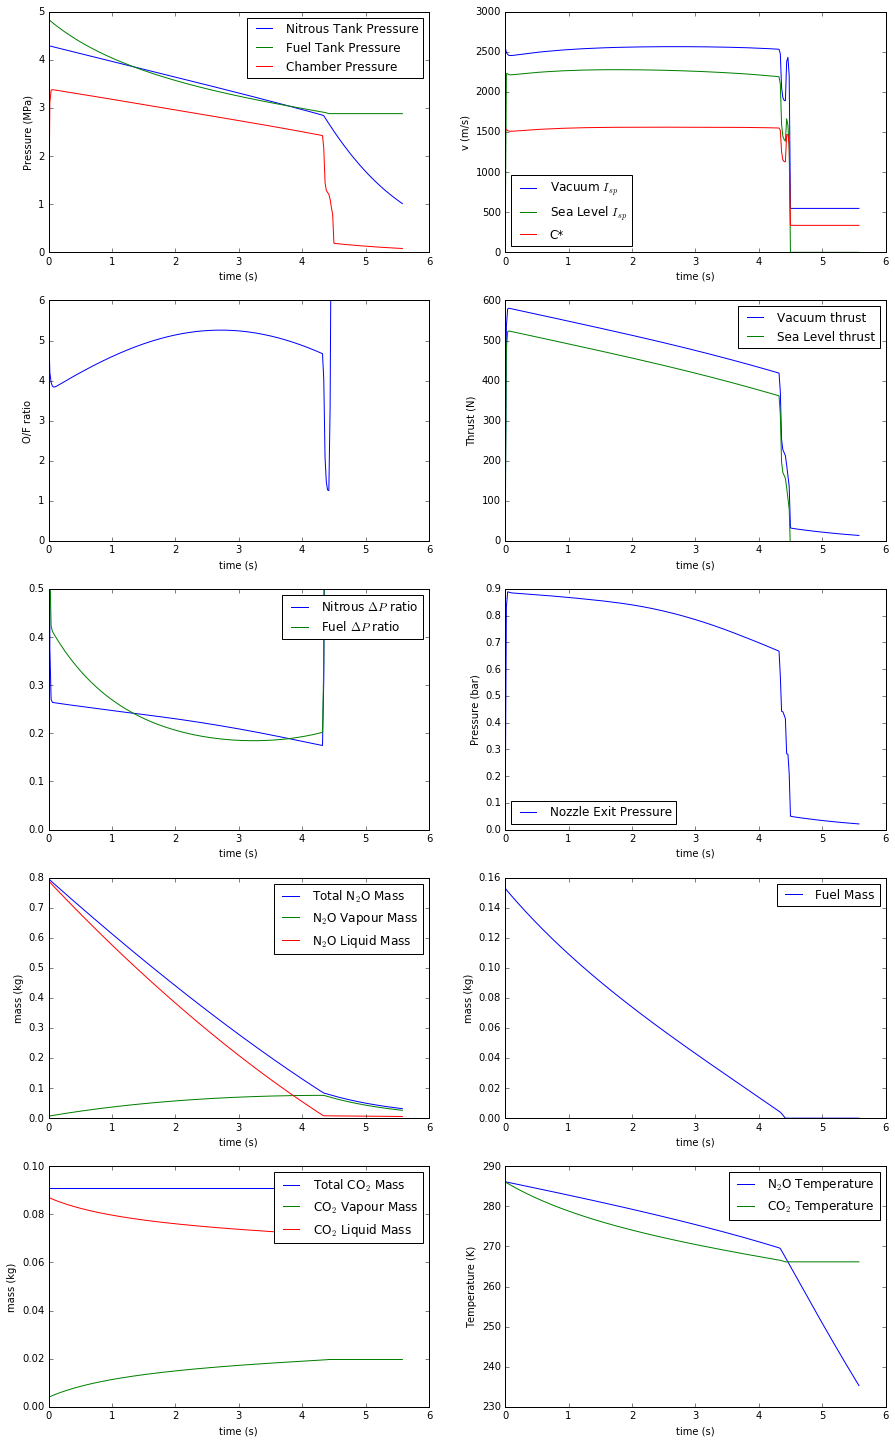

In [162]:
%pylab inline

figsize(15,25)

fig=plt.figure()

print("Minimum pressure drop ratio (nitrous) = {:.4f}".format(np.amin((extraHist[7,:]-extraHist[6,:])/np.maximum(extraHist[6,:],1e4*ones(num_points)))))
print("Minimum pressure drop ratio (fuel) = {:.4f}".format(np.amin((extraHist[8,:]-extraHist[6,:])/np.maximum(extraHist[6,:],1e4*ones(num_points)))))

print("Liftoff thrust = {:.1f} N".format(np.amax(extraHist[14,:])))
print("Propellant mass = {:.3f} kg".format(initial_ox_m_tot + rho_f*(fuel_tank_vol_init-initial_fp_vol)))
print("Total propellant tank volume = {:.3f} L".format((fuel_tank_vol_init+V_ox_tank)*1000))

print("Fuel pressurant mass = {:.3f} kg".format(fp_mass_total))

impulse = sum(extraHist[14,:])*time_res
print("Total impulse = {:.1f} Ns (motor class: {})".format(impulse, chr(ord('A')+int(np.log2(impulse/1.25)))))

sp1=fig.add_subplot(521)
sp1.plot(time,extraHist[7,:]/1e6, label="Nitrous Tank Pressure")
sp1.plot(time,extraHist[8,:]/1e6, label="Fuel Tank Pressure")
sp1.plot(time,extraHist[6,:]/1e6, label="Chamber Pressure")
sp1.legend(loc=1)
sp1.set_xlabel("time (s)")
sp1.set_ylabel("Pressure (MPa)")

sp2 = fig.add_subplot(522)
sp2.plot(time,extraHist[10,:], label="Vacuum $I_{sp}$")
sp2.plot(time,np.maximum(extraHist[11,:],np.zeros_like(extraHist[11,:])), label="Sea Level $I_{sp}$")
sp2.plot(time,extraHist[9,:], label="C*")
sp2.legend(loc=3)
sp2.set_xlabel("time (s)")
sp2.set_ylabel("v (m/s)")

sp3 = fig.add_subplot(523)
sp3.plot(time,extraHist[12,:], label="O/F ratio$")
sp3.set_ylim([0,6])
sp3.set_xlabel("time (s)")
sp3.set_ylabel("O/F ratio")

sp4 = fig.add_subplot(524)
sp4.plot(time,extraHist[13,:], label="Vacuum thrust")
sp4.plot(time,extraHist[14,:], label="Sea Level thrust")
sp4.legend(loc=1)
sp4.set_ylim(ymin=0)
sp4.set_xlabel("time (s)")
sp4.set_ylabel("Thrust (N)")

sp5=fig.add_subplot(525)
sp5.plot(time,(extraHist[7,:]-extraHist[6,:])/np.maximum(extraHist[6,:],1e4*ones(num_points)), label="Nitrous $\Delta P$ ratio")
sp5.plot(time,(extraHist[8,:]-extraHist[6,:])/np.maximum(extraHist[6,:],1e4*ones(num_points)), label="Fuel $\Delta P$ ratio")
sp5.legend(loc=1)
sp5.set_ylim([0,0.5])
sp5.set_xlabel("time (s)")

sp6=fig.add_subplot(526)
sp6.plot(time,extraHist[15,:]/1e5, label="Nozzle Exit Pressure")
sp6.legend(loc=3)
sp6.set_xlabel("time (s)")
sp6.set_ylabel("Pressure (bar)")

sp7=fig.add_subplot(527)
sp7.plot(time,stateHist[0,:], label="Total N$_2$O Mass")
sp7.plot(time,extraHist[16,:], label="N$_2$O Vapour Mass")
sp7.plot(time,extraHist[17,:], label="N$_2$O Liquid Mass")
sp7.legend(loc=1)
sp7.set_xlabel("time (s)")
sp7.set_ylabel("mass (kg)")

sp8=fig.add_subplot(528)
sp8.plot(time,(fuel_tank_vol_init - stateHist[2,:])*rho_f, label="Fuel Mass")
sp8.legend(loc=1)
sp8.set_xlabel("time (s)")
sp8.set_ylabel("mass (kg)")
sp8.set_ylim(ymin=0)

sp9=fig.add_subplot(529)
sp9.plot(time,ones(num_points)*fp_mass_total, label="Total CO$_2$ Mass")
sp9.plot(time,extraHist[18,:], label="CO$_2$ Vapour Mass")
sp9.plot(time,extraHist[19,:], label="CO$_2$ Liquid Mass")
sp9.legend(loc=1)
sp9.set_xlabel("time (s)")
sp9.set_ylabel("mass (kg)")

sp10=fig.add_subplot(5, 2, 10)
sp10.plot(time,extraHist[20,:], label="N$_2$O Temperature")
sp10.plot(time,extraHist[21,:], label="CO$_2$ Temperature")
sp10.legend(loc=1)
sp10.set_xlabel("time (s)")
sp10.set_ylabel("Temperature (K)")

## Some Observations

- That went better than I expected. Not too much variation in mixture ratio (note that the $I_{sp}$ curve is essentially flat during the main burn), and the swing in $\Delta P$ ratio for the fuel injector isn't absurd. (Though for this thrust level the fuel injector orifices do still need to be quite small. A fuel-centred pintle, for example, would probably want six 0.55-mm-diameter orifices, which would be tricky to drill. My first experiment for this project would be to see just how small a hole I could successfully drill!)
- A nice thing about the design above is that it works when temperatures are slightly different, as long as the correct masses of nitrous oxide and carbon dioxide have been loaded and that everything is at approximately the same temperature. I haven't done a full sensitivity study, but I tried running it at slightly different temperatures (N2O saturation pressure at 4.8 MPa (290.9 K) and 3.8 MPa (281.0 K)) and got essentially the same "shape": that is, more or less the same total impulse, but with a shorter higher-thrust burn for higher temperatures, and a longer lower-thrust burn for lower temperatures. The shutdown transient had a slightly different shape (fuel ran out earlier/later in the oxidiser vapour phase), and the total impulse varied somewhat due to the varying densities of the nitrous oxide.

It may still be worth comparing this with the "mostly-empty blowdown tank" approach. This method does introduce extra mass (in the example above, the liquid CO2 masses 91 grams, versus the ~33 grams of nitrogen which would be needed in the equivalent "mostly-empty blowdown" system. Plus there's the piston mass to consider. On the flip side, there's less tankage mass!). 

(But the correct answer in this case is "whichever one works well enough and is simplest to handle. This is not supposed to be a high-performance propulsion system.)